## more advanced version of nlp_1

In [62]:
import spacy
from spacy.matcher import Matcher, PhraseMatcher

nlp = spacy.load("en_core_web_sm")

In [63]:
sample_description = (
    "Bright red color and initial aromas dominated by a spicy note that, coupled "
    "with fruity notes of cherry and strawberry, creates a delightful bouquet. "
    "On the palate it is fresh and delicate, with medium tannins and a persistent finish."
)

doc = nlp(sample_description)

In [64]:
# --------------------------------------------------------------------------------
# 1) DEFINE A COMPREHENSIVE DICTIONARY OF WINE DESCRIPTORS
# --------------------------------------------------------------------------------

FLAVOR_LEXICON = {
    "fruity": ["fruity", "fruit", "berry", "berry-like", "cherry", "strawberry", "blueberry", 
               "raspberry", "blackberry", "citrus", "lemon", "lime", "tropical", "apple", "pear"],
    "spicy": ["spicy", "peppery", "cinnamon", "clove", "pepper", "nutmeg"],
    "earthy": ["earthy", "mushroom", "forest floor", "damp soil", "loamy"],
    "floral": ["floral", "violet", "rose", "lilac", "blossom"],
    "fresh": ["fresh", "crisp", "lively", "zesty"],
    "oaky": ["oaky", "oak", "vanilla", "toast", "woody"],
    "sweet": ["sweet", "honeyed", "candied", "sugary"],
    "tannic": ["tannic", "firm tannins", "grippy"],
    "delicate": ["delicate", "light"],
    "rich": ["rich", "full-bodied", "lush", "opulent"],
    # add more, maybe parse the descriptions to find most common words or something? idk
}

COLOR_TERMS = ["red", "white", "rosé", "ruby", "garnet", "straw", "gold", "purple", "deep", "bright"]
AROMA_TERMS = ["aroma", "aromas", "nose", "bouquet", "smell"]
FLAVOR_TERMS = ["flavor", "taste", "notes", "profile", "palate"]
FINISH_TERMS = ["finish", "length", "aftertaste"]
MOUTHFEEL_TERMS = ["mouthfeel", "texture", "tannin", "tannins", "acidity", "palate", "body"]

In [65]:
# --------------------------------------------------------------------------------
# 2) BUILD MATCH PATTERNS
# --------------------------------------------------------------------------------
matcher = Matcher(nlp.vocab)

# A) ADJ + NOUN (e.g., "spicy notes", "fresh acidity", "persistent finish")
pattern_adj_noun = [
    {"POS": "ADJ"},         # e.g., "spicy"
    {"POS": "NOUN"}         # e.g., "notes"
]
matcher.add("ADJ_NOUN", [pattern_adj_noun])

# B) NOUN + NOUN (e.g., "berry aroma", "cherry nose", "fruit notes")
pattern_noun_noun = [
    {"POS": "NOUN"},
    {"POS": "NOUN"}
]
matcher.add("NOUN_NOUN", [pattern_noun_noun])

# You could add more patterns, such as ADJ + ADJ + NOUN, or "ADJ + 'and' + ADJ + NOUN", etc.

pattern_adj_adj_noun = [
    {"POS": "ADJ"},
    {"POS": "ADJ"},
    {"POS": "NOUN"}
]

matcher.add("ADJ_ADJ_NOUN", [pattern_adj_adj_noun])

matches = matcher(doc)

In [66]:
# --------------------------------------------------------------------------------
# 3) FUNCTION: MAP A TOKEN OR PHRASE TO A KNOWN FLAVOR CATEGORY
# --------------------------------------------------------------------------------
def get_flavor_category(token_text):
    """
    Check if a word/phrase matches (or is contained in) any entry in FLAVOR_LEXICON.
    Return the first matching category or None if no match.
    """
    token_text_lower = token_text.lower()
    for cat, synonyms in FLAVOR_LEXICON.items():
        for syn in synonyms:
            if syn in token_text_lower:
                return cat
    return None

In [67]:
# --------------------------------------------------------------------------------
# 4) COLLECT RESULTS
# --------------------------------------------------------------------------------

color = []
aromas = []
flavors = []
finish = []
mouthfeel = []

# First pass to find direct color references:
for token in doc:
    # If this token or its lemma is in color terms, track it
    if token.text.lower() in COLOR_TERMS or token.lemma_.lower() in COLOR_TERMS:
        color.append(token.text)

# More advanced color extraction, ie capture the "Bright red color" as a chunk
for chunk in doc.noun_chunks:
    if "color" in chunk.text.lower():
        # Find all adjectives or color tokens in that chunk
        for word in chunk:
            if word.pos_ in ("ADJ", "NOUN") and word.text.lower() in COLOR_TERMS:
                color.append(word.text)

# Parse the matched phrases for aroma/flavor/finish contexts:
for match_id, start, end in matches:
    span = doc[start:end]  # the phrase
    # e.g. "spicy notes", "berry aroma", "persistent finish"
    cat = get_flavor_category(span.text)
    
    # We want to see if the phrase is near "aromas", "finish", etc.
    # We'll look at a window around the phrase or the words inside it.
    # For simplicity, we can look at the actual tokens within the span:
    phrase_text = span.text.lower().split()
    
    # Check adjacency or membership with known context terms:
    # If the phrase itself has the word "aroma" or "notes", we treat it differently
    # Or if neighbor tokens in the doc have those keywords
    local_context = []
    
    # Gather some neighboring tokens
    left_window = doc[max(0, start-3):start]
    right_window = doc[end:end+3]
    local_context_tokens = [t.text.lower() for t in left_window] + [t.text.lower() for t in span] + [t.text.lower() for t in right_window]
    
    # Decide category based on context keywords
    if any(term in local_context_tokens for term in AROMA_TERMS):
        # phrase is likely describing aroma
        if cat is not None:
            aromas.append(cat)
        else:
            aromas.append(span.text)  # fallback, store raw phrase
    elif any(term in local_context_tokens for term in FINISH_TERMS):
        if cat is not None:
            finish.append(cat)
        else:
            finish.append(span.text)
    elif any(term in local_context_tokens for term in MOUTHFEEL_TERMS):
        if cat is not None:
            mouthfeel.append(cat)
        else:
            mouthfeel.append(span.text)
    else:
        # default to "flavor"
        if cat is not None:
            flavors.append(cat)
        else:
            flavors.append(span.text)

In [68]:
# --------------------------------------------------------------------------------
# 5) DEDUP & FINALIZE
# --------------------------------------------------------------------------------
#remove duplicates
color = list(set(color))
aromas = list(set(aromas))
flavors = list(set(flavors))
finish = list(set(finish))
mouthfeel = list(set(mouthfeel))

wine_profile = {
    "color": color,
    "aromas": aromas,
    "flavors": flavors,
    "finish": finish,
    "mouthfeel": mouthfeel
}

print(wine_profile)


{'color': ['red', 'Bright'], 'aromas': ['delicate', 'initial aromas', 'red color', 'Bright red color'], 'flavors': ['fruity', 'spicy'], 'finish': ['persistent finish'], 'mouthfeel': ['medium tannins']}


In [69]:
#Initial Input
sample_description_input = (
    "Bright red color and initial aromas dominated by a spicy note that, coupled "
    "with fruity notes of cherry and strawberry, creates a delightful bouquet. "
    "On the palate it is fresh and delicate, with medium tannins and a persistent finish."
)

#Sample Output

sample_output = {
 'color': ['red', 'Bright'], 
 'aromas': ['delicate', 'initial aromas', 'red color'], 
 'flavors': ['fruity', 'spicy'], 
 'finish': ['persistent finish'], 
 'mouthfeel': ['medium tannins']
 }

## Part 2
# Create a CSV with all the wine data parsed

In [70]:
#now lets create a csv of ALL THE WINES!! 
import pandas as pd

#Import the CSV (TRANSLATED!!)
starting_file = '../../Resources/BlogOsVinhosTranslated.csv'

df_start = pd.read_csv(starting_file)
df_start.head(5)

,Name,Region,Year,Color,Castes,Alcohol_Percentage,Winery,Min_Price,Max_Price,Judge,Judge_Rating,Review_Date,Review_Notes,Wine_Bottle_Label,URL
0,.Beb 2007,Regional Alentejo,2007.0,Rosé,"Cabernet Sauvignon, Syrah e Touriga Nacional",13.5,Tiago Mateus Cabaço e Cabaço,4.0,7.5,Tiago Cabaço,15.5,12/2008,Bright red color and initial aromas dominated ...,It has an attractive color and an intense arom...,https://osvinhos.blogspot.com/2010/03/1232-beb...
1,.Beb 2009,Regional Alentejo,2009.0,Red,"Cabernet Sauvignon, Syrah, Alicante Bouschet e...",14.0,Tiago Mateus Cabaço e Cabaço,7.5,10.0,Susana Esteban,16.0,11/2012,"Reddish color and very aromatic nose, where th...",The careful choice of the best installments of...,https://osvinhos.blogspot.com/2013/08/2803-beb...
2,.Beb 2010,Regional Alentejo,2010.0,Red,"Cabernet Sauvignon, Syrah, Alicante Bouschet e...",14.0,Tiago Mateus Cabaço e Cabaço,7.5,10.0,Tiago Cabaço,16.0,08/2013,It presents a pleasantly concentrated ruby ​​c...,The careful choice of the best installments of...,https://osvinhos.blogspot.com/2014/01/2988-beb...
3,.Beb 2011,Regional Alentejo,2011.0,White,"Arinto, Roupeiro e Viognier",13.5,Tiago Mateus Cabaço e Cabaço,7.5,10.0,Tiago Cabaço e Susana Esteban,15.5,09/2012,Bright yellow color and delicately marked nose...,We associated a very old wardrobe vineyard wit...,https://osvinhos.blogspot.com/2013/09/2820-beb...
4,.Beb 2012,Regional Alentejo,2012.0,White,"Encruzado, Verdelho e Viognier",13.5,Tiago Mateus Cabaço e Cabaço,4.0,7.5,Tiago Cabaço e Susana Esteban,16.0,07/2014,It has a slightly pale yellow color and a nose...,We associated the structure and complexity of ...,https://osvinhos.blogspot.com/2015/06/3639-beb...


In [71]:
#Parse the DF to what we want
df = df_start[['Name', 'Color', 'Alcohol_Percentage', 'Judge_Rating', 'Review_Notes','Wine_Bottle_Label','URL']]

#df.head(5)

#Feature Engineering Price

#df['Price'] = (df_start['Min_Price'] + df_start['Max_Price']) / 2

df.loc[:, 'Price'] = (df_start['Min_Price'] + df_start['Max_Price']) / 2

df.head(5)

C:\Users\micha\AppData\Local\Temp\ipykernel_8324\2081011267.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Price'] = (df_start['Min_Price'] + df_start['Max_Price']) / 2


,Name,Color,Alcohol_Percentage,Judge_Rating,Review_Notes,Wine_Bottle_Label,URL,Price
0,.Beb 2007,Rosé,13.5,15.5,Bright red color and initial aromas dominated ...,It has an attractive color and an intense arom...,https://osvinhos.blogspot.com/2010/03/1232-beb...,5.75
1,.Beb 2009,Red,14.0,16.0,"Reddish color and very aromatic nose, where th...",The careful choice of the best installments of...,https://osvinhos.blogspot.com/2013/08/2803-beb...,8.75
2,.Beb 2010,Red,14.0,16.0,It presents a pleasantly concentrated ruby ​​c...,The careful choice of the best installments of...,https://osvinhos.blogspot.com/2014/01/2988-beb...,8.75
3,.Beb 2011,White,13.5,15.5,Bright yellow color and delicately marked nose...,We associated a very old wardrobe vineyard wit...,https://osvinhos.blogspot.com/2013/09/2820-beb...,8.75
4,.Beb 2012,White,13.5,16.0,It has a slightly pale yellow color and a nose...,We associated the structure and complexity of ...,https://osvinhos.blogspot.com/2015/06/3639-beb...,5.75


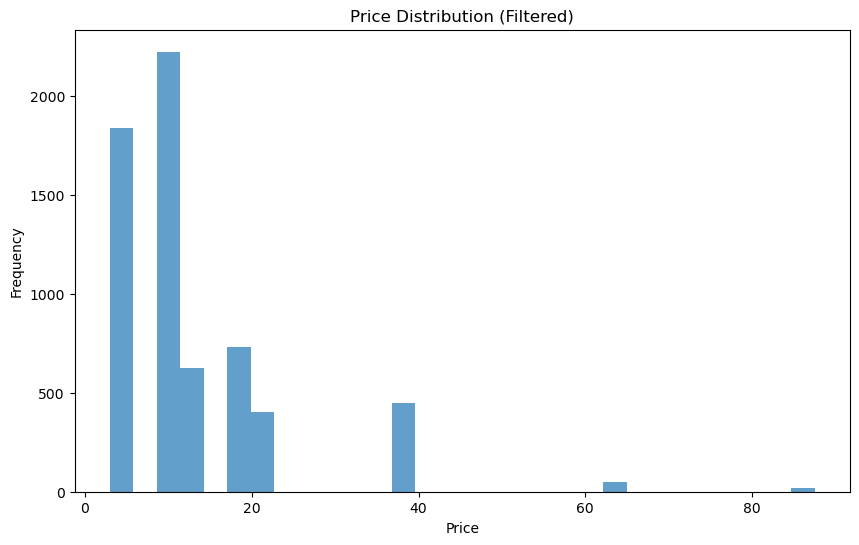

In [72]:
import matplotlib.pyplot as plt

# Define a threshold to filter out outliers
threshold = 1000

# Filter the DataFrame to exclude outliers
filtered_df = df[df['Price'] < threshold]

# Distribution chart (Histogram)
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['Price'], bins=30, alpha=0.7)
plt.title('Price Distribution (Filtered)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [73]:
df.head(5)

,Name,Color,Alcohol_Percentage,Judge_Rating,Review_Notes,Wine_Bottle_Label,URL,Price
0,.Beb 2007,Rosé,13.5,15.5,Bright red color and initial aromas dominated ...,It has an attractive color and an intense arom...,https://osvinhos.blogspot.com/2010/03/1232-beb...,5.75
1,.Beb 2009,Red,14.0,16.0,"Reddish color and very aromatic nose, where th...",The careful choice of the best installments of...,https://osvinhos.blogspot.com/2013/08/2803-beb...,8.75
2,.Beb 2010,Red,14.0,16.0,It presents a pleasantly concentrated ruby ​​c...,The careful choice of the best installments of...,https://osvinhos.blogspot.com/2014/01/2988-beb...,8.75
3,.Beb 2011,White,13.5,15.5,Bright yellow color and delicately marked nose...,We associated a very old wardrobe vineyard wit...,https://osvinhos.blogspot.com/2013/09/2820-beb...,8.75
4,.Beb 2012,White,13.5,16.0,It has a slightly pale yellow color and a nose...,We associated the structure and complexity of ...,https://osvinhos.blogspot.com/2015/06/3639-beb...,5.75


In [46]:
# Apply the function to each row in the DataFrame
#df['wine_profile'] = df['Review_Notes'].apply(extract_wine_profile)
#i dont think we need anymore i have this 2 cells below

C:\Users\micha\AppData\Local\Temp\ipykernel_8324\393567456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wine_profile'] = df['Review_Notes'].apply(extract_wine_profile)


In [74]:
#Reformat step 4 into a function

def extract_wine_profile(review_notes):
    doc = nlp(review_notes)
    matches = matcher(doc)
    
    color = []
    aromas = []
    flavors = []
    finish = []
    mouthfeel = []

    for token in doc:
        if token.text.lower() in COLOR_TERMS or token.lemma_.lower() in COLOR_TERMS:
            color.append(token.text)
    
    for chunk in doc.noun_chunks:
        if "color" in chunk.text.lower():
            for word in chunk:
                if word.pos_ in ("ADJ", "NOUN") and word.text.lower() in COLOR_TERMS:
                    color.append(word.text)
    
    for match_id, start, end in matches:
        span = doc[start:end]
        cat = get_flavor_category(span.text)
        phrase_text = span.text.lower().split()
        local_context_tokens = [t.text.lower() for t in doc[max(0, start-3):start]] + [t.text.lower() for t in span] + [t.text.lower() for t in doc[end:end+3]]
        
        if any(term in local_context_tokens for term in AROMA_TERMS):
            if cat is not None:
                aromas.append(cat)
            else:
                aromas.append(span.text)
        elif any(term in local_context_tokens for term in FINISH_TERMS):
            if cat is not None:
                finish.append(cat)
            else:
                finish.append(span.text)
        elif any(term in local_context_tokens for term in MOUTHFEEL_TERMS):
            if cat is not None:
                mouthfeel.append(cat)
            else:
                mouthfeel.append(span.text)
        else:
            if cat is not None:
                flavors.append(cat)
            else:
                flavors.append(span.text)

    color = list(set(color))
    aromas = list(set(aromas))
    flavors = list(set(flavors))
    finish = list(set(finish))
    mouthfeel = list(set(mouthfeel))
    
    return {
        "color": color,
        "aromas": aromas,
        "flavors": flavors,
        "finish": finish,
        "mouthfeel": mouthfeel
    }

In [75]:
# Apply the function to each row in the DataFrame
df['wine_profile'] = df['Review_Notes'].apply(extract_wine_profile)


C:\Users\micha\AppData\Local\Temp\ipykernel_8324\393567456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wine_profile'] = df['Review_Notes'].apply(extract_wine_profile)


In [76]:
df.head(5)

,Name,Color,Alcohol_Percentage,Judge_Rating,Review_Notes,Wine_Bottle_Label,URL,Price,wine_profile
0,.Beb 2007,Rosé,13.5,15.5,Bright red color and initial aromas dominated ...,It has an attractive color and an intense arom...,https://osvinhos.blogspot.com/2010/03/1232-beb...,5.75,"{'color': ['red', 'Bright'], 'aromas': ['initi..."
1,.Beb 2009,Red,14.0,16.0,"Reddish color and very aromatic nose, where th...",The careful choice of the best installments of...,https://osvinhos.blogspot.com/2013/08/2803-beb...,8.75,"{'color': ['red'], 'aromas': ['aromatic nose']..."
2,.Beb 2010,Red,14.0,16.0,It presents a pleasantly concentrated ruby ​​c...,The careful choice of the best installments of...,https://osvinhos.blogspot.com/2014/01/2988-beb...,8.75,"{'color': ['red', 'ruby'], 'aromas': ['floral'..."
3,.Beb 2011,White,13.5,15.5,Bright yellow color and delicately marked nose...,We associated a very old wardrobe vineyard wit...,https://osvinhos.blogspot.com/2013/09/2820-beb...,8.75,"{'color': ['Bright'], 'aromas': [], 'flavors':..."
4,.Beb 2012,White,13.5,16.0,It has a slightly pale yellow color and a nose...,We associated the structure and complexity of ...,https://osvinhos.blogspot.com/2015/06/3639-beb...,5.75,"{'color': [], 'aromas': ['pale yellow color', ..."


In [77]:
# Expand the wine_profile dictionary into separate columns
df = df.join(df['wine_profile'].apply(pd.Series))


In [78]:
df.head(5)

,Name,Color,Alcohol_Percentage,Judge_Rating,Review_Notes,Wine_Bottle_Label,URL,Price,wine_profile,color,aromas,flavors,finish,mouthfeel
0,.Beb 2007,Rosé,13.5,15.5,Bright red color and initial aromas dominated ...,It has an attractive color and an intense arom...,https://osvinhos.blogspot.com/2010/03/1232-beb...,5.75,"{'color': ['red', 'Bright'], 'aromas': ['initi...","[red, Bright]","[initial aromas, red color, Bright red color]","[fruity, pleasant presence, interesting set]","[average end, persistent flavor]",[]
1,.Beb 2009,Red,14.0,16.0,"Reddish color and very aromatic nose, where th...",The careful choice of the best installments of...,https://osvinhos.blogspot.com/2013/08/2803-beb...,8.75,"{'color': ['red'], 'aromas': ['aromatic nose']...",[red],[aromatic nose],"[fresh, delicate, beautiful dose, spice sugges...","[median persistence, average length]","[seductive texture, round tannins]"
2,.Beb 2010,Red,14.0,16.0,It presents a pleasantly concentrated ruby ​​c...,The careful choice of the best installments of...,https://osvinhos.blogspot.com/2014/01/2988-beb...,8.75,"{'color': ['red', 'ruby'], 'aromas': ['floral'...","[red, ruby]","[floral, fruity]","[fruity, attractive wine, several spices, spic...",[long length],[round tannins]
3,.Beb 2011,White,13.5,15.5,Bright yellow color and delicately marked nose...,We associated a very old wardrobe vineyard wit...,https://osvinhos.blogspot.com/2013/09/2820-beb...,8.75,"{'color': ['Bright'], 'aromas': [], 'flavors':...",[Bright],[],"[yellow color, medium structure, Bright yellow...",[],[]
4,.Beb 2012,White,13.5,16.0,It has a slightly pale yellow color and a nose...,We associated the structure and complexity of ...,https://osvinhos.blogspot.com/2015/06/3639-beb...,5.75,"{'color': [], 'aromas': ['pale yellow color', ...",[],"[pale yellow color, yellow color, fruity, mine...","[oaky, fresh, elegant mineral, mineral notes, ...",[],[well acidity]


In [79]:
# Drop the original wine_profile column
df.drop(columns=['wine_profile'], inplace=True)

In [80]:
# List of columns to check for null values
columns_to_check = ["color", "aromas", "flavors", "finish", "mouthfeel"]

# Function to check for empty lists
def count_empty_lists(column):
    return column.apply(lambda x: len(x) == 0).sum()

# Sum the empty lists in each column
empty_list_counts = df[columns_to_check].apply(count_empty_lists)

# Display the result
print(empty_list_counts)

color        2993
aromas        652
flavors        97
finish       3958
mouthfeel    1897
dtype: int64


In [81]:
# List of columns to check for empty lists
columns_to_check = ["color", "aromas", "flavors", "mouthfeel"]

# Function to check for empty lists in the specified columns
def has_empty_list(row):
    return any(len(row[col]) == 0 for col in columns_to_check)

# Apply the function to each row and count the rows with any empty lists
rows_with_empty_lists = df.apply(has_empty_list, axis=1).sum()

# Display the result
print(f"Number of rows with any empty lists in the specified columns: {rows_with_empty_lists}")

# Count the rows with any empty lists excluding the 'finish' column
columns_to_check_excluding_finish = ["color", "aromas", "flavors", "mouthfeel"]

def has_empty_list_excluding_finish(row):
    return any(len(row[col]) == 0 for col in columns_to_check_excluding_finish)

rows_with_empty_lists_excluding_finish = df.apply(has_empty_list_excluding_finish, axis=1).sum()

# Display the result
print(f"Number of rows with any empty lists excluding the 'finish' column: {rows_with_empty_lists_excluding_finish}")

Number of rows with any empty lists in the specified columns: 4197
Number of rows with any empty lists excluding the 'finish' column: 4197


# Ending of Notebook
For now, this is the end of the notebook, 4197 rows have at least 1 null list for the NLP parsing, but flavors is only missing 97 so thats pretty cool. Will continue to build out the app with this temp csv. Later will optimize this model to reduce null lists. Will use feature engineering to lower color (currently at 3k, about 50% of total sample)

color        2993

aromas        652

flavors        97

finish       3958

mouthfeel    1897

In [82]:
# Function to append the value from Color to the list in color if not already present
def append_color(row):
    if row['Color'].lower() not in row['color']:
        row['color'].append(row['Color'].lower())
    return row

# Apply the function to each row in the DataFrame
df = df.apply(append_color, axis=1)

# Display the DataFrame to verify the changes
df.head()

,Name,Color,Alcohol_Percentage,Judge_Rating,Review_Notes,Wine_Bottle_Label,URL,Price,color,aromas,flavors,finish,mouthfeel
0,.Beb 2007,Rosé,13.5,15.5,Bright red color and initial aromas dominated ...,It has an attractive color and an intense arom...,https://osvinhos.blogspot.com/2010/03/1232-beb...,5.75,"[red, Bright, rosé]","[initial aromas, red color, Bright red color]","[fruity, pleasant presence, interesting set]","[average end, persistent flavor]",[]
1,.Beb 2009,Red,14.0,16.0,"Reddish color and very aromatic nose, where th...",The careful choice of the best installments of...,https://osvinhos.blogspot.com/2013/08/2803-beb...,8.75,[red],[aromatic nose],"[fresh, delicate, beautiful dose, spice sugges...","[median persistence, average length]","[seductive texture, round tannins]"
2,.Beb 2010,Red,14.0,16.0,It presents a pleasantly concentrated ruby ​​c...,The careful choice of the best installments of...,https://osvinhos.blogspot.com/2014/01/2988-beb...,8.75,"[red, ruby]","[floral, fruity]","[fruity, attractive wine, several spices, spic...",[long length],[round tannins]
3,.Beb 2011,White,13.5,15.5,Bright yellow color and delicately marked nose...,We associated a very old wardrobe vineyard wit...,https://osvinhos.blogspot.com/2013/09/2820-beb...,8.75,"[Bright, white]",[],"[yellow color, medium structure, Bright yellow...",[],[]
4,.Beb 2012,White,13.5,16.0,It has a slightly pale yellow color and a nose...,We associated the structure and complexity of ...,https://osvinhos.blogspot.com/2015/06/3639-beb...,5.75,[white],"[pale yellow color, yellow color, fruity, mine...","[oaky, fresh, elegant mineral, mineral notes, ...",[],[well acidity]


In [83]:
# List of columns to check for null values
columns_to_check = ["color", "aromas", "flavors", "finish", "mouthfeel"]

# Function to check for empty lists
def count_empty_lists(column):
    return column.apply(lambda x: len(x) == 0).sum()

# Sum the empty lists in each column
empty_list_counts = df[columns_to_check].apply(count_empty_lists)

# Display the result
print(empty_list_counts)

color           0
aromas        652
flavors        97
finish       3958
mouthfeel    1897
dtype: int64


In [57]:
#save the df as a csv in resources
df.to_csv('../../Resources/BlogOsVinhosTranslated_With_WineProfile.csv', index=False)